# AdventureWorks - Försäljningsanalys  

I denna analys undersöker vi AdventureWorks-databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Med hjälp av SQL hämtas data och för att visualisera och analysera resultatet används Python.

In [75]:
import pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import numpy as np
import seaborn as sns

user = "SA"
password = quote_plus("Stoffe3836!")
server = 'localhost:1434'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\magda\AppData\Local\Temp\ipykernel_11756\2102306497.py:24: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [76]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori
Hur många produkter finns i varje kategori? 

Tabeller som används:
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product

Plan:  
JOINA tabellerna  
Räkna DISTINCT produkter per kategori  
Skapa vertikalt stapeldiagram  
Analysera resultatet  

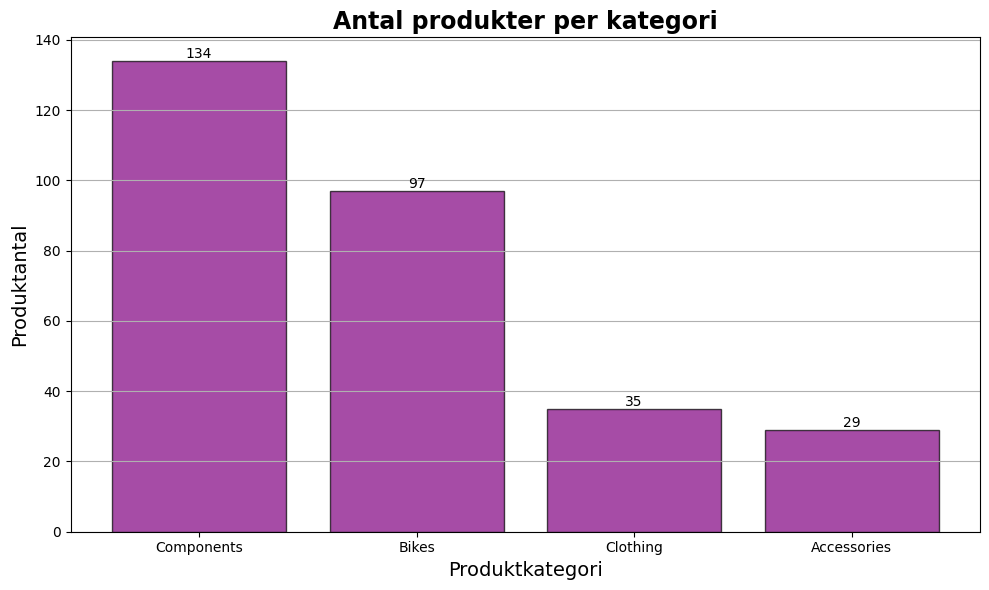

In [77]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

fig, ax = plt.subplots(figsize= (10,6))
bars = ax.bar(df_vis1["CategoryName"], df_vis1["ProductCount"], color="purple", alpha=0.7, edgecolor="black")

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

ax.set_xlabel("Produktkategori", fontsize=14)
ax.set_ylabel("Produktantal", fontsize=14)
ax.set_title("Antal produkter per kategori", fontsize=17, fontweight="bold")
ax.grid(True, axis="y")

plt.tight_layout()
plt.show()


### Analys - Antal produkter per kategori

**Komponenter** är den största kategorin med 134 produkter.  
**Accessoarer** är den minsta kategorin med endast 29 produkter.

Utifrån denna visualisering kan man se att komponenter utgör upp mot 50% av produkterna och det är här företaget har fokuserat mest.
Det kan vara en idé att marknadsföra accessoarer och kläder mer för att utöka antalet av dessa produkter.

## Visualisering 2 - Försäljning per produktkategori
Vilka produktkategorier genererar mest intäkter?

Tabeller som används:
- Production.ProductCategory 
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail

Plan:  
JOINA tabellerna  
Räkna SUM av varje produktkategori  
ORDER BY högst till lägst försäljning  
Skapa Horisontellt stapeldiagram  
Analysera reslutatet  

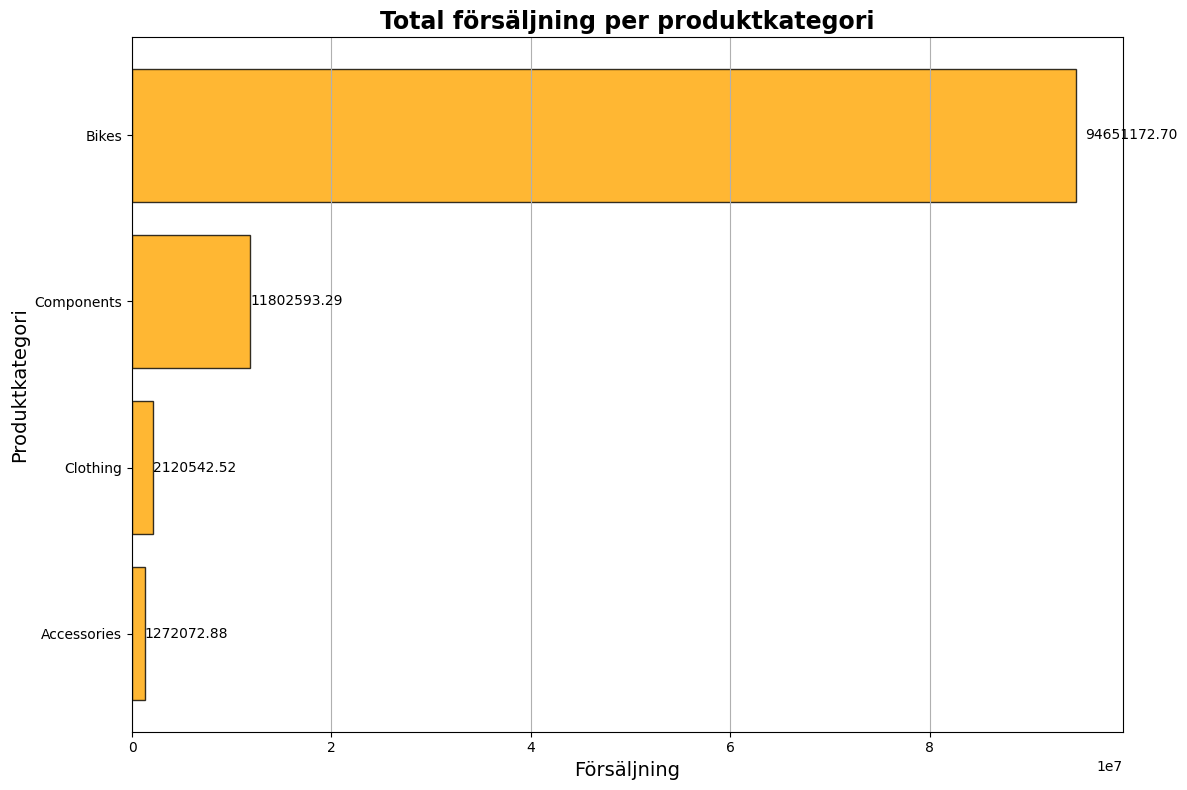

In [78]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalRevenue
FROM Sales.SalesOrderDetail sod
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY pc.Name
ORDER BY TotalRevenue DESC
"""

df_vis2 = query_df(query_vis2)

fig, ax = plt.subplots(figsize=(12,8))

h_bar = ax.barh(df_vis2["CategoryName"], df_vis2["TotalRevenue"], color="orange", edgecolor="black", alpha=0.8)

for bar in h_bar:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height()/2
    ax.text(
    width * 1.01,
    y,
    f"{width:.2f}",
    va="center",
    ha="left"
    )

ax.set_title("Total försäljning per produktkategori", fontsize=17, fontweight="bold")
ax.set_xlabel("Försäljning", fontsize=14)
ax.set_ylabel("Produktkategori", fontsize=14)
ax.grid(True, axis="x")
ax.invert_yaxis() 
plt.tight_layout()
plt.show()


### Analys - Försäljning per produktkategori

Kategorin som har den högsta försäljningen i siffror är **cyklar** som ligger på totalt 94651172.704731.  
Kategorin med den lägsta försäljningen är **accessoarer** som ligger på 1272072.883926.


## Visualisering 3 - Försäljningstrend över tid
Hur har försäljningen utvecklats över tid?

Tabell som används:
- Sales.SalesOrderHeader

Plan:  
Aggregera per månad (minst 12 månader data)  
Sortera kronologiskt (äldst först)  
Skapa Linjediagram (line plot)   
Analysera resultatet 


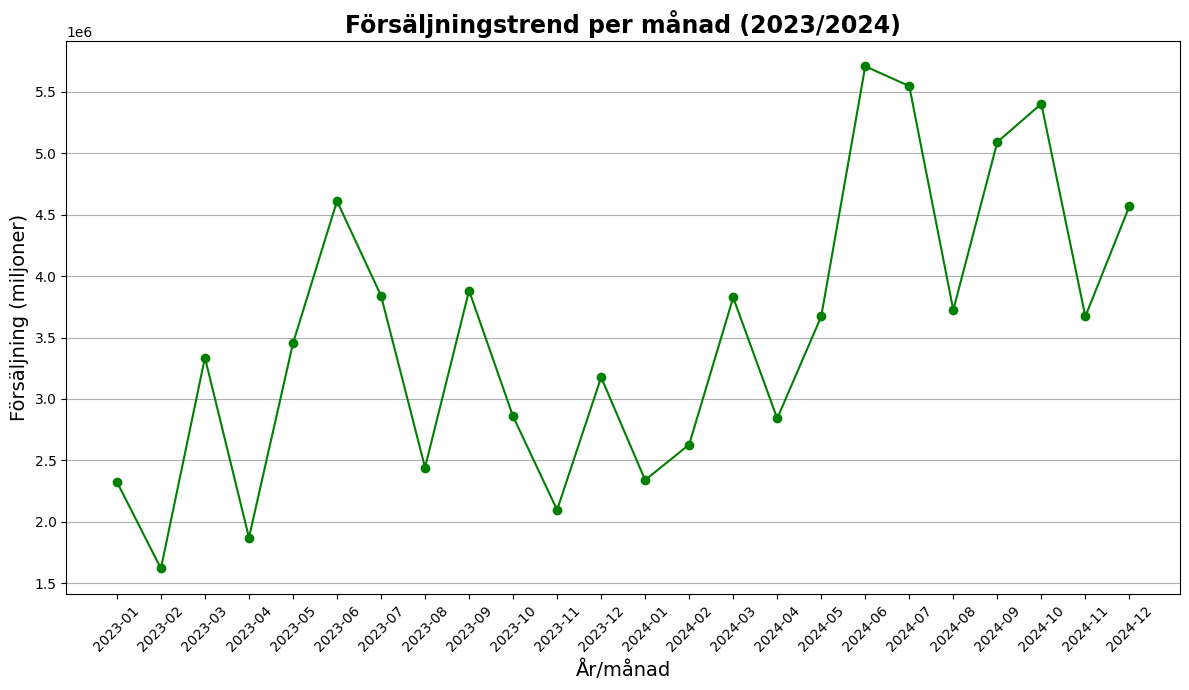

In [79]:
query_vis3 = """
SELECT 
    FORMAT(OrderDate, 'yyyy-MM') AS YearMonth,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
WHERE OrderDate >= '2023-01-01'
AND OrderDate < '2025-01-01'
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY YearMonth ASC;
"""

df_vis3 = query_df(query_vis3)

fig, ax = plt.subplots(figsize=(12,7))
plot = ax.plot(df_vis3["YearMonth"], df_vis3["TotalSales"], marker="o", color="green")
ax.set_title("Försäljningstrend per månad (2023/2024)", fontsize=17, fontweight="bold")
ax.set_xlabel("År/månad", fontsize=14)
ax.set_ylabel("Försäljning (miljoner)", fontsize=14)
ax.grid(True, axis="y")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Analys - Försäljningstrend per månad
Analysen av månadsvis försäljning för åren 2023 och 2024 visar en tydlig ökning under 2024 jämfört med föregående år.  
Den högsta försäljningsnivån observeras i juni 2024, medan den lägsta försäljningen inträffar i februari 2023.  

Ett tydligt säsongsmönster kan identifieras, där försäljningen ökar under sommarmånaderna. Detta mönster återfinns även under 2023, då juni var den starkaste försäljningsmånaden även det året.  
Resultatet indikerar att efterfrågan är som högst under sommaren, vilket bör beaktas vid planering av marknadsföring och lagerhållning.

## Visualisering 4 - Försäljning och antal ordrar per år
Hur ser total försäljning och antal ordrar ut per år?

Tabell som används:   
- Sales.SalesOrderHeader

Plan:  
Räkna Antal ordrar (COUNT)  
Räkna total försäljning (SUM)  
Gruppera per år  
Sortera kronologiskt  
Grupperat stapeldiagram  
Analysera resultatet

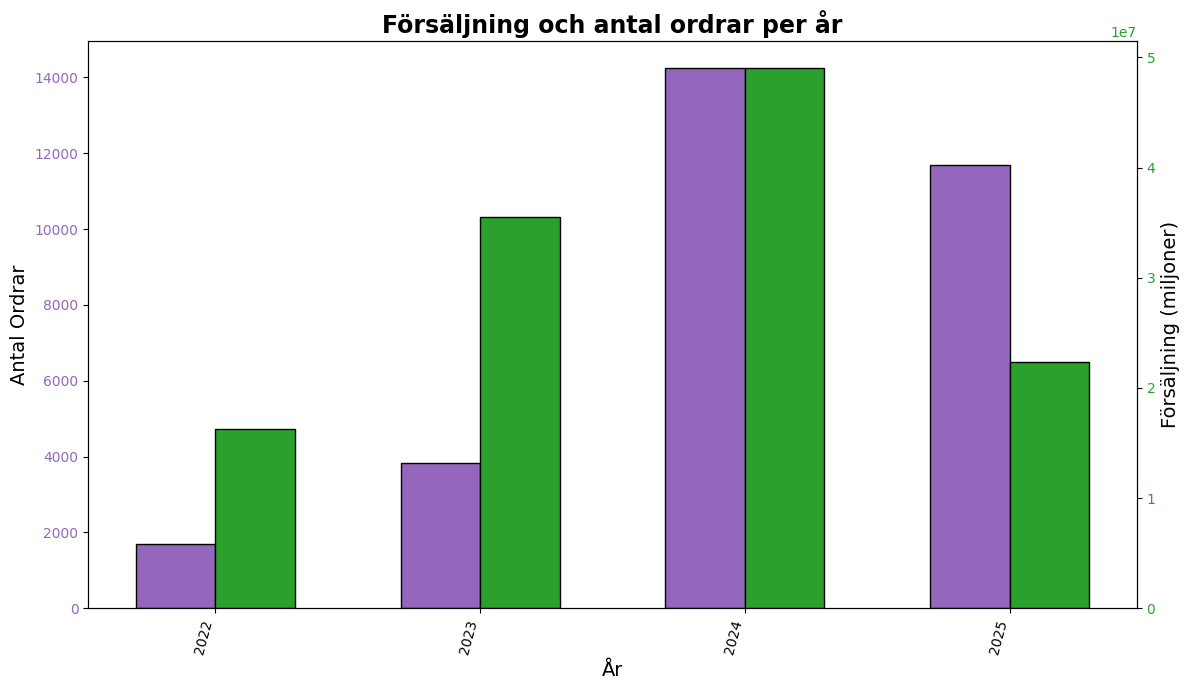

In [80]:
query_vis4 = """ 
SELECT
    YEAR(OrderDate) AS Year,
    COUNT(SalesOrderID) AS Orders,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate) 
ORDER BY Year ASC
"""

df_vis4 = query_df(query_vis4)

idx = np.arange(len(df_vis4["Year"]))
width = 0.3

fig, ax1 = plt.subplots(figsize=(12,7))
ax2 = ax1.twinx()

bar_orders = ax1.bar(idx - width/2, df_vis4["Orders"], width, label="Antal Ordrar", color="tab:purple", edgecolor="black")
bar_totalsales = ax2.bar(idx + width/2, df_vis4["TotalSales"], width, label="Försäljning", color="tab:green", edgecolor="black")


ax1.set_title("Försäljning och antal ordrar per år", fontsize=17, fontweight="bold")
ax1.set_xlabel("År", fontsize=14)
ax1.set_ylabel("Antal Ordrar", fontsize=14)
ax2.set_ylabel("Försäljning (miljoner)", fontsize=14)
ax1.set_xticks(idx)
ax1.set_xticklabels(df_vis4["Year"], rotation=75, ha="right")
ax1.tick_params(axis="y", labelcolor="tab:purple")
ax2.tick_params(axis="y", labelcolor="tab:green")

plt.tight_layout()
plt.show()



### Analys - Försäljning och antal ordrar per år
Visualiseringen visar att både antalet ordrar och den totala försäljningen når sin högstanivå under 2024, medan 2022 är det svagaste året sett till båda måtten.  

Det kan även observeras att relationen mellan försäljning och antal ordrar förändras över tid. Fram till 2024 har försäljningen ökat i högre takt än antalet ordrar, vilket indikerar ett högre genomsnittligt ordervärde.  
Under 2025 vänder dock denna trend, där antalet ordrar fortsätter att öka medan försäljningen inte följer samma utveckling.  

Detta kan tyda på ett sjunkande genomsnittligt ordervärde eller minskade vinstmarginaler, vilket bör analyseras vidare för att säkerställa lönsamheten.

## Visualisering 5 -  Top 10 produkter
Vilka 10 produkter genererar mest försäljning?

Tabeller som används:
- Production.Product
- Sales.SalesOrderDetail

Plan:  
JOINA Tabellerna  
Räkna SUM försäljning per produkt  
Ta ut TOP 10 produkter  
Sortera från högst till lägst försäljning  
Visualisera med ett horisontellt stapeldiagram (högst överst)  
Analysera resultatet

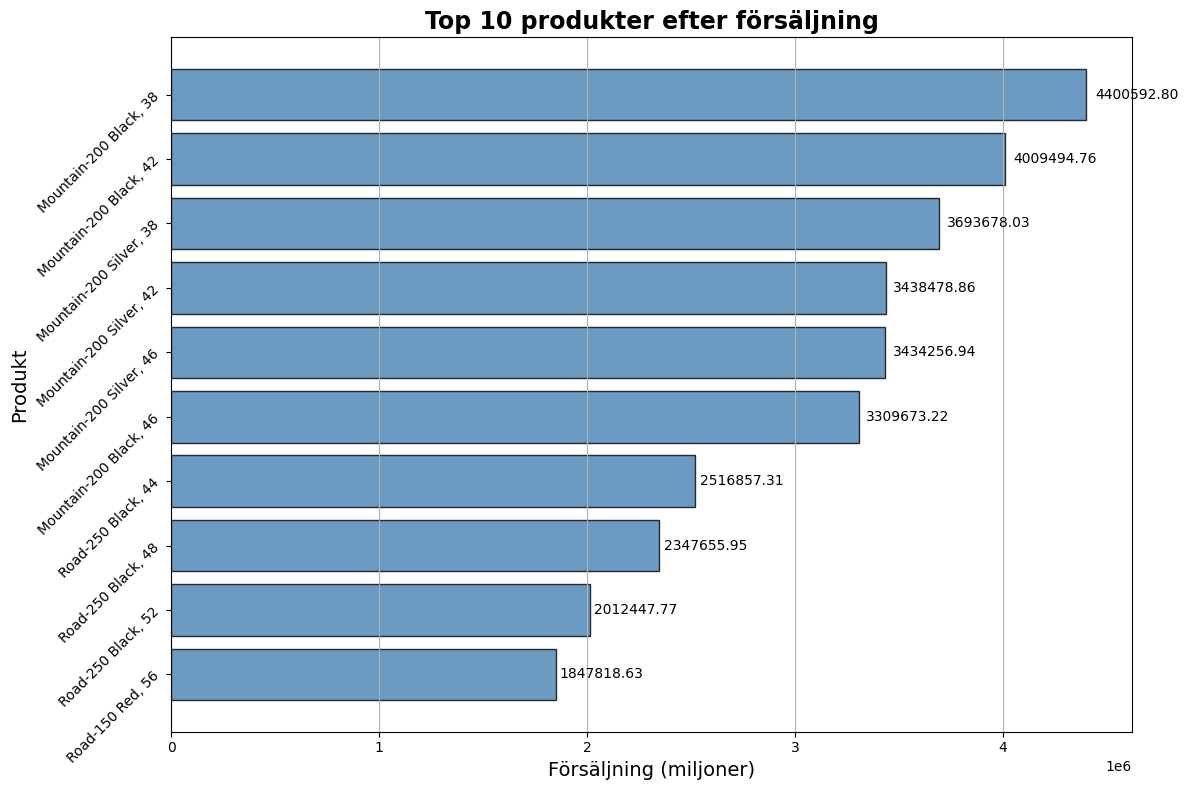

In [81]:
query_vis5 = """
SELECT TOP 10 
    p.Name AS ProductName,
    SUM(sod.LineTotal) AS TotalSum
FROM Sales.SalesOrderDetail sod 
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
GROUP BY p.Name
ORDER BY TotalSum DESC
"""

df_vis5 = query_df(query_vis5)


fig, ax = plt.subplots(figsize=(12,8))

barh = ax.barh(df_vis5["ProductName"], df_vis5["TotalSum"], color="steelblue", edgecolor="black", alpha=0.8)

for bar in barh:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height()/2
    ax.text(
        width * 1.01,
        y,
        f"{width:.2f}",
        va="center",
        ha="left"
    )

ax.set_title("Top 10 produkter efter försäljning", fontsize=17, fontweight="bold")
ax.set_xlabel("Försäljning (miljoner)", fontsize=14)
ax.set_ylabel("Produkt", fontsize=14)
ax.invert_yaxis() 
ax.grid(True, axis="x")
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()



### Analys - TOP 10 produkter efter försäljning

Analysen visar att samtliga produkter på TOP 10 - listan är från kategorin **cyklar**.   
Produkten med mest försäljning är **Mountain-200 Black, 38** där totalsumman ligger på 4400592.80.

## Visualisering 6 - Försäljning och antal kunder per region
Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?


Tabeller som används:  
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer

Plan:  
Räkna kunder per Region (COUNT)  
Summera total försäljning per region (SUM)  
Sortera från högst till lägst försäljning    
Grupperat stapeldiagram (grouped bar) med två staplar per region   
Analysera resultatet  


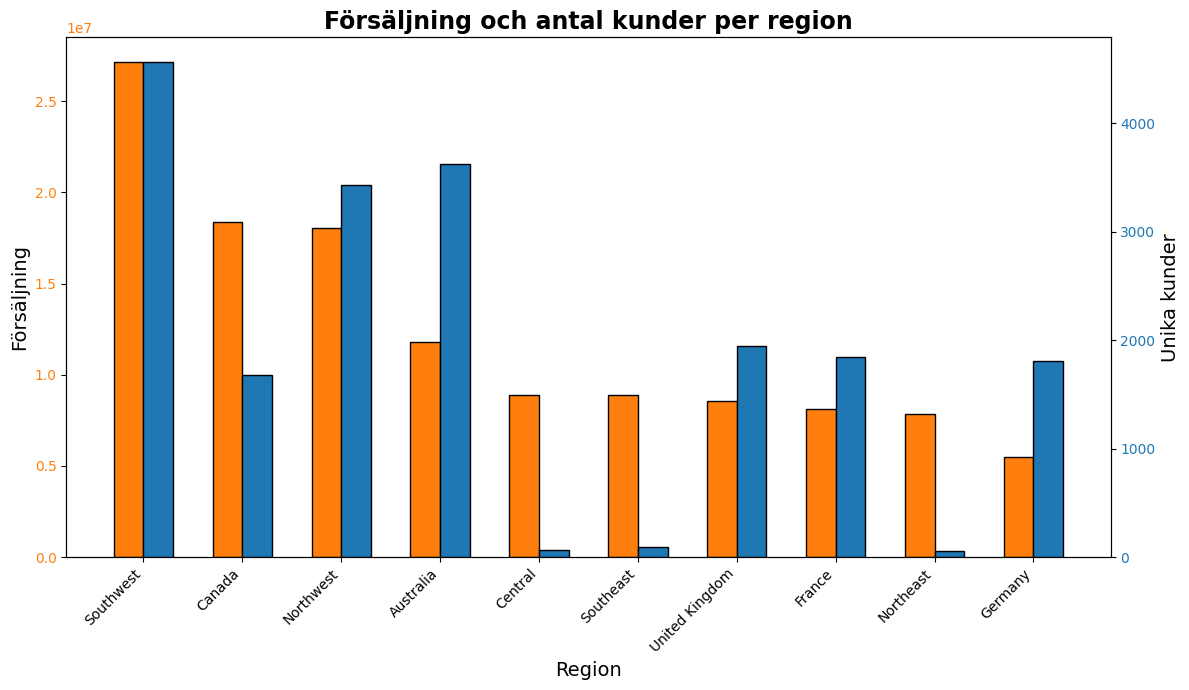

In [82]:
query_vis6 = """ 
SELECT 
    st.Name AS Region,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT c.CustomerID) AS Customers
FROM Sales.SalesTerritory st
INNER JOIN Sales.SalesOrderHeader soh ON st.TerritoryID = soh.TerritoryID
INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC
"""

df_vis6 = query_df(query_vis6)

idx = np.arange(len(df_vis6["Region"]))
width = 0.3

fig, ax1 = plt.subplots(figsize=(12,7))
ax2 = ax1.twinx()

bar_regions = ax1.bar(idx - width/2, df_vis6["TotalSales"], width, label="Försäljning", color="tab:orange", edgecolor="black")
bar_customers = ax2.bar(idx + width/2, df_vis6["Customers"], width, label="Unika kunder", color="tab:blue", edgecolor="black")


ax1.set_title("Försäljning och antal kunder per region", fontsize=17, fontweight="bold")
ax1.set_xlabel("Region", fontsize=14)
ax1.set_ylabel("Försäljning", fontsize=14)
ax2.set_ylabel("Unika kunder", fontsize=14)
ax1.set_xticks(idx)
ax1.set_xticklabels(df_vis6["Region"], rotation=45, ha="right")
ax1.tick_params(axis="y", labelcolor="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:blue")

plt.tight_layout()
plt.show()

### Analys - Försäljning och antal kunder per region

Regionen Southwest är starkast både när det kommer till försäljning och antal unika kunder.  
Svagast försäljning har Tyskland men de har däremot fler antal unika kunder än en del andra regioner som till exempel Northeast och Central.


## Visualisering 7 - Genomsnittligt ordervärde per region och kundtyp
Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

Tabeller som används:
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer
- Sales.Store

Plan:  
JOINA Tabellerna  
CASE - vilka ordrar tillhör företag och vilka tillhör privatpersoner  
Räkna genomsnittligt ordervärde   
Pivot dataframe  
Visa resultat med ett grupperat stapeldiagram  
Analysera resultatet  



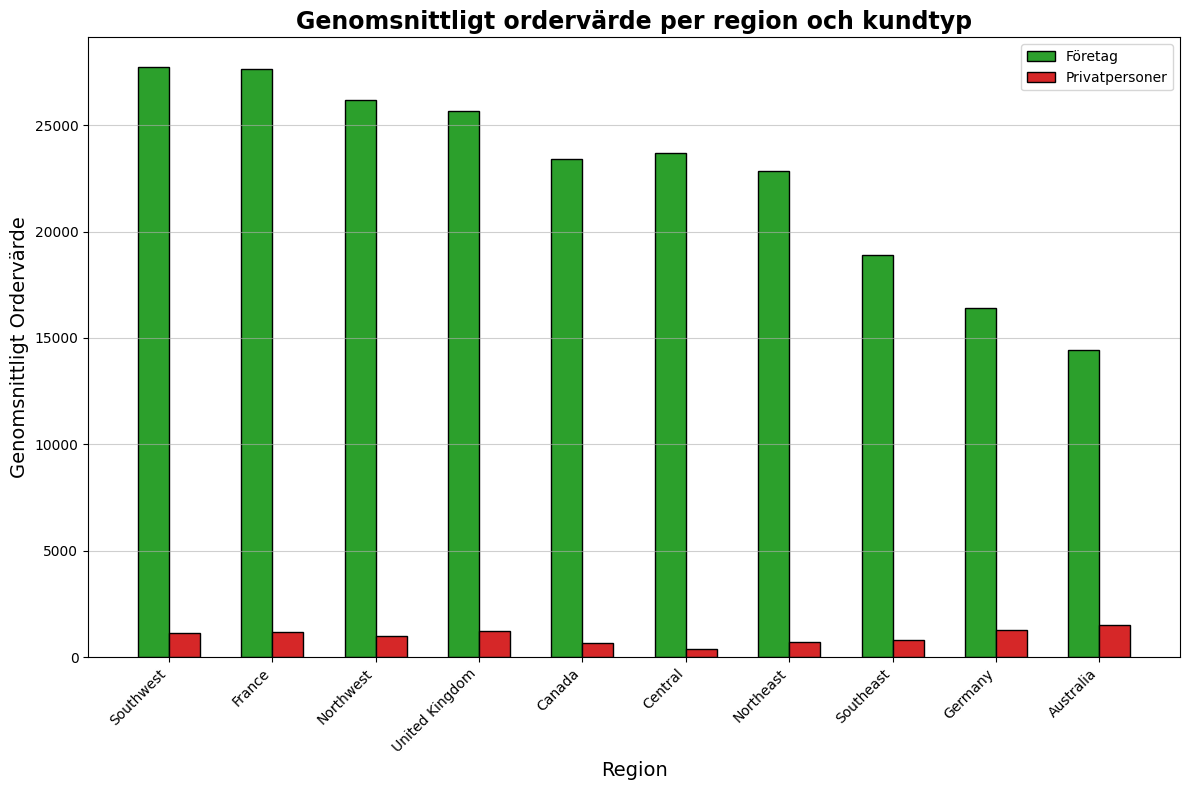

In [83]:
query_vis7 = """
SELECT
    st.Name AS Region,
    CASE
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END AS CustomerType,
    SUM(soh.TotalDue) / COUNT(soh.SalesOrderID) AS AverageOrderValue
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
LEFT JOIN Sales.Store s ON c.StoreID = s.BusinessEntityID
GROUP BY st.Name,
    CASE 
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END
ORDER BY AverageOrderValue DESC;
"""

df_vis7 = query_df(query_vis7)

pivot_df = df_vis7.pivot(
    index="Region",
    columns="CustomerType",
    values="AverageOrderValue"
)

pivot_df["TotalAvg"] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values("TotalAvg", ascending=False)
pivot_df = pivot_df.drop(columns="TotalAvg")


idx = np.arange(len(pivot_df))
width = 0.3

fig, ax = plt.subplots(figsize=(12,8))

bar_store = ax.bar(idx - width/2, pivot_df["Store"], width, label="Företag", color="tab:green", edgecolor="black")
bar_individual = ax.bar(idx + width/2, pivot_df["Individual"], width, label="Privatpersoner", color="tab:red", edgecolor="black")


ax.set_title("Genomsnittligt ordervärde per region och kundtyp", fontsize=17, fontweight="bold")
ax.set_xlabel("Region", fontsize=14)
ax.set_ylabel("Genomsnittligt Ordervärde", fontsize=14)
ax.set_xticks(idx)
ax.set_xticklabels(pivot_df.index, rotation=45, ha="right")
ax.legend(loc='upper right')
ax.grid(True, axis="y", alpha=0.6)

plt.tight_layout()
plt.show()



### Analys - Genomsnittligt ordervärde per region och kundtyp
Analysen visar tydliga skillnader i genomsnittligt ordervärde mellan kundtyper, där företagskunder har avsevärt högre ordervärden än privatpersoner. Detta är förväntat, då företagskunder ofta köper större volymer per order.  

Southwest är den region som uppvisar högst genomsnittligt ordervärde för företagskunder, medan Australien har det lägsta. Utan ytterliggare data är det svårt att fastställa den exakta orsaken till detta, men möjliga förklaringar kan vara högre fraktkostnader, geografiska avstånd eller skillnader i kundstruktur mellan regionerna.   

Resultatet indikerar att det finns en potential att öka ordervärdet i vissa regioner genom riktade strategier mot företagskunder.

## Djupanalys - Regional försäljningsoptimering


### Försäljning och antal kunder per region

Vilken region presterar bäst/sämst?  

Tabeller som används:
- Sales.SalesOrderHeader   
- Sales.SalesTerritory  

Plan:    
Räkna kunder per Region (COUNT)    
Summera total försäljning per region (SUM)    
Sortera från högst till lägst försäljning      
Grupperat stapeldiagram (grouped bar) med två staplar per region     
Analysera resultatet    

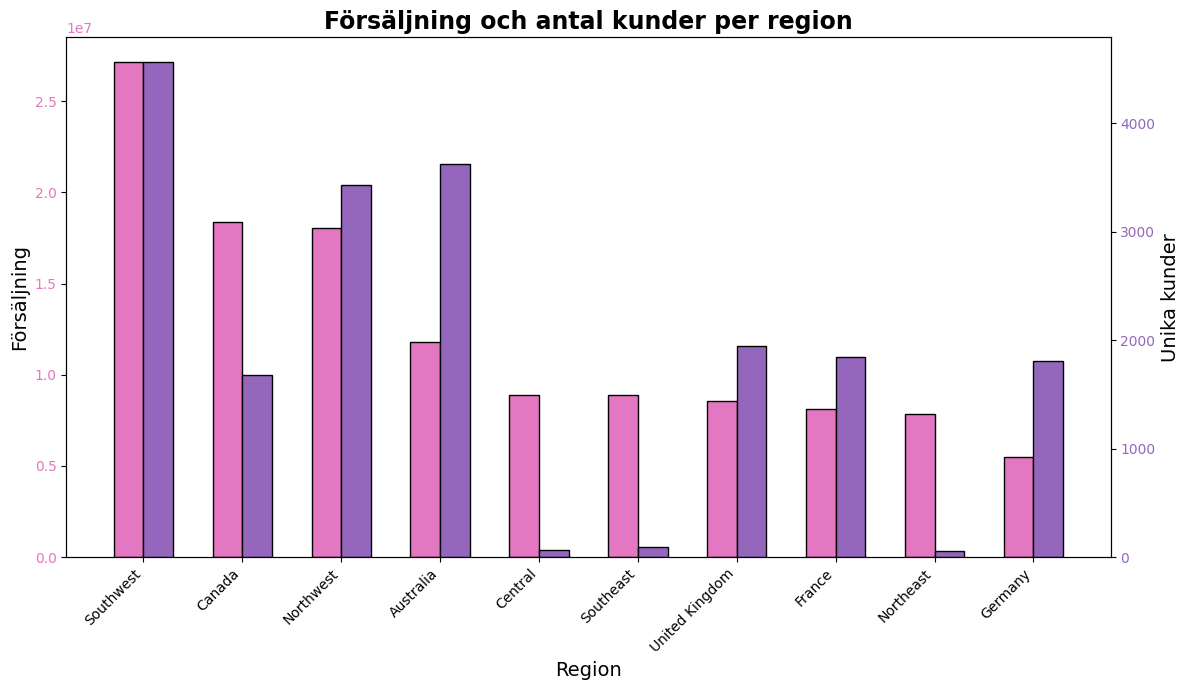

In [84]:
query_vis6 = """ 
SELECT 
    st.Name AS Region,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT c.CustomerID) AS Customers
FROM Sales.SalesTerritory st
INNER JOIN Sales.SalesOrderHeader soh ON st.TerritoryID = soh.TerritoryID
INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC
"""

df_vis6 = query_df(query_vis6)

idx = np.arange(len(df_vis6["Region"]))
width = 0.3

fig, ax1 = plt.subplots(figsize=(12,7))
ax2 = ax1.twinx()

bar_regions = ax1.bar(idx - width/2, df_vis6["TotalSales"], width, label="Försäljning", color="tab:pink", edgecolor="black")
bar_customers = ax2.bar(idx + width/2, df_vis6["Customers"], width, label="Unika kunder", color="tab:purple", edgecolor="black")


ax1.set_title("Försäljning och antal kunder per region", fontsize=17, fontweight="bold")
ax1.set_xlabel("Region", fontsize=14)
ax1.set_ylabel("Försäljning", fontsize=14)
ax2.set_ylabel("Unika kunder", fontsize=14)
ax1.set_xticks(idx)
ax1.set_xticklabels(df_vis6["Region"], rotation=45, ha="right")
ax1.tick_params(axis="y", labelcolor="tab:pink")
ax2.tick_params(axis="y", labelcolor="tab:purple")

plt.tight_layout()
plt.show()

### Analys - Försäljning och antal kunder per region
Grafen visar tydliga skillnader mellan regionerna vad gäller både försäljning och antal unika kunder. **Southwest** är den starkast presterande regionen, med både högst försäljning och flest unika kunder, vilket indikerar en bred och stabil kundbas.  

Australien ligger på fjärde plats när det kommer till försäljning men har näst flest unika kunder, vilket tyder på ett lägre genomsnittligt ordervärde jämfört med andra regioner.     

Tyskland har den lägsta försäljningen trots ett relativt högt antal kunder jämfört med Central, Southeast och Northeast. Detta kan indikera på att dessa 3 regioner säljer mer till företagskunder med större ordervärden.

### Försäljning per region och produktkategori

Vilka produktkategorier säljer bäst var?  

Tabeller som används:
- Sales.SalesOrderHeader  
- Sales.SalesOrderDetail 
- Production.Product  
- Production.ProductSubcategory  
- Production.ProductCategory  
- Sales.SalesTerritory  

Plan:  
JOINA Tabellerna
Räkna SUM av total försäljning  
GRUPPERA per Region och Kateogori  
PIVOT dataframe  
Visa resultat med Heathmap  
Analysera resultatet  

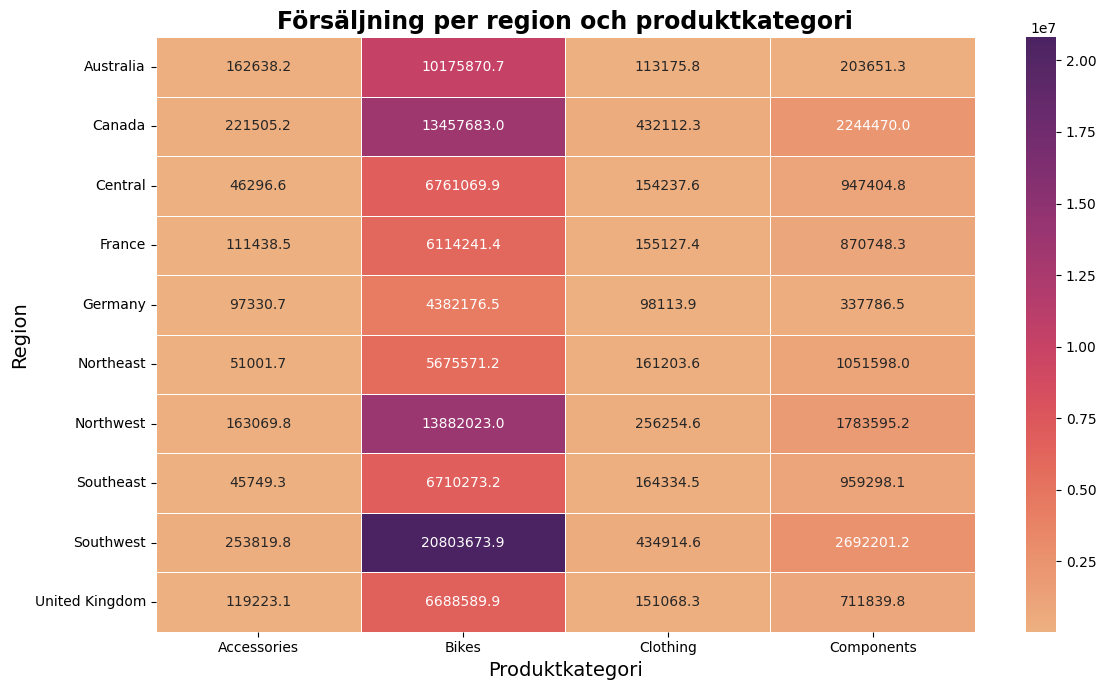

In [85]:
query_vis8 = """
SELECT
    st.Name AS Region,
    pc.Name AS Category,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail sod
INNER JOIN Sales.SalesOrderHeader soh ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory ps ON p.ProductSubcategoryID = ps.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc ON ps.ProductCategoryID = pc.ProductCategoryID
GROUP BY st.Name, pc.Name;
"""

df_vis8 = query_df(query_vis8)

pivot_df8 = df_vis8.pivot(
    index="Region",
    columns="Category",
    values="TotalSales"
)

import seaborn as sns

plt.figure(figsize=(12,7))
sns.heatmap(pivot_df8, cmap="flare", linewidths=0.5, annot=True, fmt=".1f")

plt.title("Försäljning per region och produktkategori", fontsize=17, fontweight="bold")
plt.xlabel("Produktkategori", fontsize=14)
plt.ylabel("Region", fontsize=14)
plt.tight_layout()
plt.show()


### Analys - Försäljning per region och gruppkategori
Analysen visar att kategorin **Cyklar** dominerar försäljningen i samtliga regioner, vilket indikerar att detta är företagets viktigaste produktkategori. 
  
Southwest utmärker sig särskilt med den högsta cykelförsäljningen på cirka **20,8 miljoner**, vilket stärker bilden av regionen som företagets starkaste marknad.  
Övriga produktkategorier står för en betydligt mindre del av försäljningen, vilket visar på ett tydligt beroende av cykelförsäljning.

### Säsongsmönster i försäljning per region (2024)

Finns säsongsmönster per region?  

Tabeller som används:
- Sales.SalesOrderHeader  
- Sales.SalesTerritory  

Plan:    
JOINA Tabellerna  
Räkna Total försäljning (SUM)  
Ta ut endast försäljning 2024 (WHERE)  
ORDER BY År, Månad  
Visualisera med linjediagram  
Analysera resultatet  

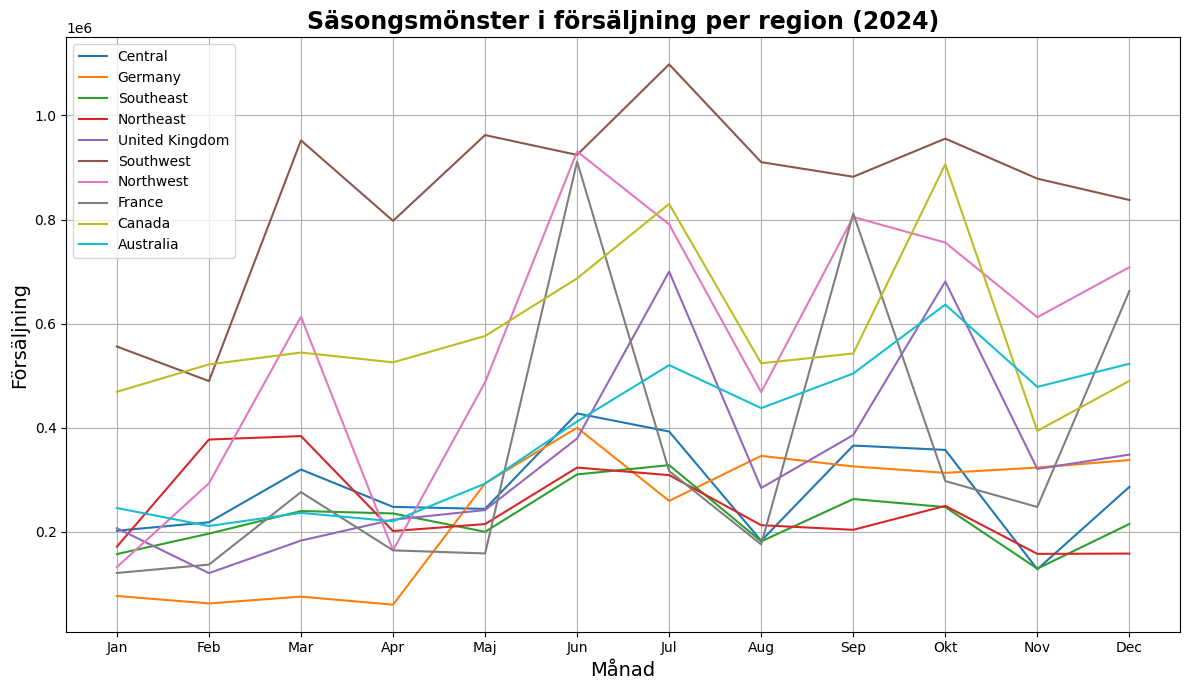

In [86]:
query_vis9 = """
SELECT 
    st.Name AS Region,
    YEAR(OrderDate) AS [Year],
    MONTH(OrderDate) AS [Month],
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
WHERE OrderDate >= '2024-01-01'
AND OrderDate < '2025-01-01'
GROUP BY st.Name, YEAR(OrderDate), MONTH(OrderDate)
ORDER BY [Year], [Month]
"""

df_vis9 = query_df(query_vis9)

fig, ax = plt.subplots(figsize=(12,7))

for region in df_vis9["Region"].unique():
    data = df_vis9[df_vis9["Region"] == region]
    ax.plot(data["Month"], data["TotalSales"], label=region)

ax.set_title("Säsongsmönster i försäljning per region (2024)", fontsize=17, fontweight="bold")
ax.set_xlabel("Månad", fontsize=14)
ax.set_ylabel("Försäljning", fontsize=14)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "Maj", "Jun",
     "Jul", "Aug", "Sep", "Okt", "Nov", "Dec"]
)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

### Analys - Säsongsmönster i försäljning per region (2024)
För år 2024 visar flera regioner tydliga säsongsmönster.  
Frankrike uppvisar kraftiga försäljningstoppar i **juni** och **september**, följt av markanta nedgångar under **juli-augusti** samt i **oktober**, vilket kan indikera en semesterrelaterad efterfrågan.

Kanada och Australien har däremot sina högsta försäljningssiffror i **oktober**, vilket kan kopplas till regionala skillnader i klimat och köpbeteende. 

Generellt sett har de flesta regioner lägre försäljning under perioden **januari** till **maj**.

### Säsongsmönster i försäljning per region (hela datasetet)

Finns säsongsmönster per region?  

Tabeller som används:
- Sales.SalesOrderHeader  
- Sales.SalesTerritory  

Plan:    
JOINA Tabellerna  
Räkna Total försäljning (SUM)     
ORDER BY År  
Visualisera med linjediagram  
Analysera resultatet  

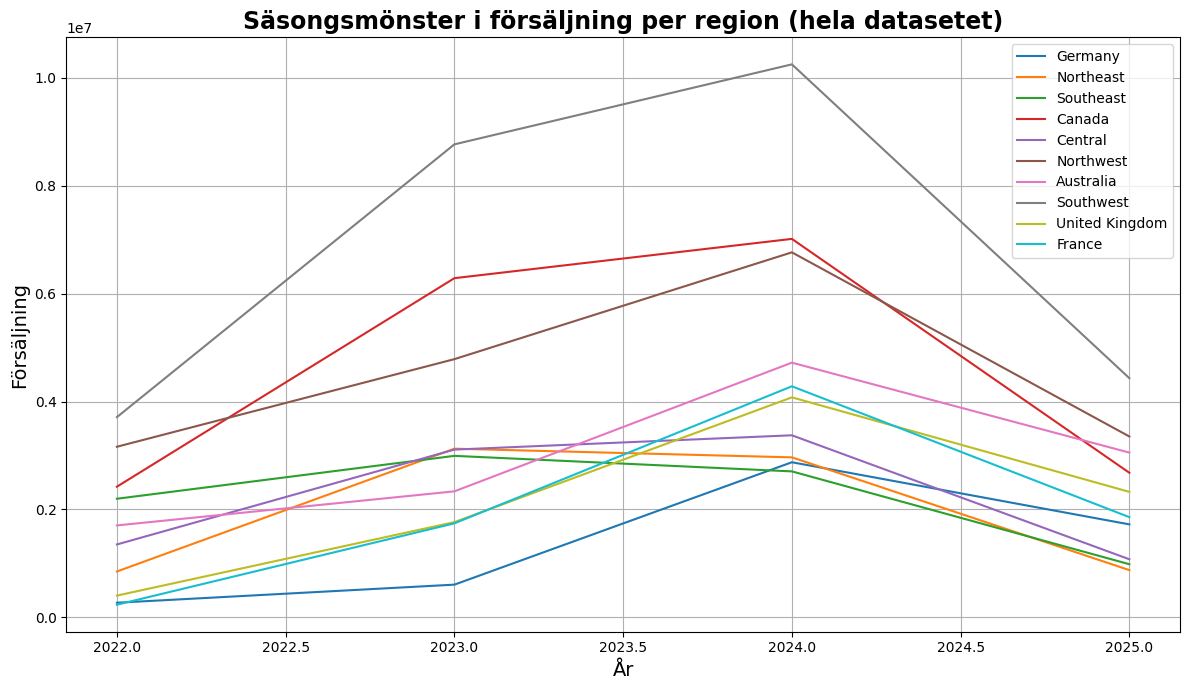

In [87]:
query_vis10 = """
SELECT 
    st.Name AS Region,
    YEAR(OrderDate) AS [Year],
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
GROUP BY st.Name, YEAR(OrderDate)
ORDER BY [Year]
"""

df_vis10 = query_df(query_vis10)

fig, ax = plt.subplots(figsize=(12,7))

for region in df_vis10["Region"].unique():
    data = df_vis10[df_vis10["Region"] == region]
    ax.plot(data["Year"], data["TotalSales"], label=region)

ax.set_title("Säsongsmönster i försäljning per region (hela datasetet)", fontsize=17, fontweight="bold")
ax.set_xlabel("År", fontsize=14)
ax.set_ylabel("Försäljning", fontsize=14)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


### Analys - Säsongsmönster i försäljning per region (hela datasetet)
Vid analys av hela datasetet syns en tydlig nedgång i försäljningen från och med 2024 för samtliga regioner. För **Northeast** och **Southeast** kan denna negativa trend observeras redan från 2023.  

Detta kan indikera förändringar i marknadsförutsättningar, minskad efterfrågan eller ökad konkurrens och bör analyseras vidare.

## Rekommendationer 
- Fokusera investeringar på Southwest, som visar stark försäljning och stor kundbas. Regionen kan fungera som referens för framgångsrika strategier i andra regioner.
- Öka genomsnittligt ordervärde i Australien genom riktade kampanjer mot företagskunder eller genom merförsäljning, då regionen har många kunder men relativt lägre försäljning.
- Öka antalet unika kunder i regionerna Central, Southeast och Northeast genom marknadsföring mot privatpersoner.
- Diversifiera produktutbudet i regioner med stark cykelförsäljning för att minska beroendet av en enskild produktkategori.
- Anpassa marknadsföring efter säsongsmönster, exempelvis genom att förstärka kampanjer inför identifierade högsäsonger såsom juni, september och oktober.
- Analysera försäljningsnedgången efter 2023–2024 för att identifiera bakomliggande orsaker och vidta åtgärder i regioner med negativ trend.

## Reflektion:  

Jag valde att göra en djupanalys inom regional försäljningsoptimering eftersom jag tycker det är intressant att identifiera mönster i historisk försäljningsdata. Genom att analysera hur försäljningen har utvecklats över tid och mellan regioner kan man få en bättre förståelse för vilka faktorer som påverkar resultatet, samt undersöka om analysen kan användas för att påverka framtida trender och beslut.  

Mitt mål var att undersöka hur försäljningen skiljer sig mellan olika regioner och om det finns återkommande mönster eller trender som kan användas för att optimera framtida försäljningsstrategier.  

Jag valde att göra aggregeringen i SQL eftersom jag upplever att det blir tydligare och mer strukturerat att sammanfatta datan redan från början. Genom att använda SQL kunde jag arbeta med ett renare och mer färdigt dataset när jag gick vidare till analys och visualisering.  

Jag ttycker att de diagramtyper jag valde gav det tydligaste visuella resultatet för att visa skillnader och trender i datan. De gjorde det lätt att jämföra regioner, följa utveckling över tid och snabbt identifiera mönster som annars hade varit svårare att se i tabellform.  

Pivot tables hjälpte mig att strukturera och sammanfatta datan på ett överskådligt sätt. Då man grupperar informationen blir det enklare att upptäcka samband och mönster.  

Jag stötte inte på några större utmaningar mer än justeringar och olika tester av kod för att få fram det resultatet jag efterfrågade.